# 本筆記將帶大家用Keras建模
# 此範例使用MNIST手寫數字資料集

---

# 索引

[1. 資料準備](#I.-資料準備)
  * [1.a. 載入圖片](#1.a.-載入圖片)
  * [1.b. 利用Pandas可迅速了解每個資料夾裡面有幾張圖片](#1.b.-利用Pandas可迅速了解每個資料夾裡面有幾張圖片)
  * [1.c. 將圖片路徑資料切割成三份：取其80%做為train-data。 之後，剩下的20%中的10%做validation data，10%做test data](#1.c.-將圖片路徑資料切割成三份：取其80%做為train-data。-之後，剩下的20%中的10%做validation-data，10%做test-data)
  * [1.d. 將圖片載入，存成數值矩陣](#1.d.-將圖片載入，存成數值矩陣)
  

[2. Softmax Regression](#2.-Softmax-Regression)

  * [2.a. 將y 轉成one hot形式](#2.a.-將y-轉成one-hot形式)
  * [2.b. 開始建立模型](#2.b.-開始建立模型)
  * [2.c. 開始訓練模型](#2.c.-開始訓練模型)
  * [2.d. 檢視訓練好的模型用於test data有多少準確率](#2.d.-檢視訓練好的模型用於test-data有多少準確率)
  * [2.e. 檢視50筆測試資料的預測結果，以稍為了解預測是否還算ok](#2.e.-檢視50筆測試資料的預測結果，以稍為了解預測是否還算ok)
  * [2.f. 畫出模型訓練過程](#2.f.-畫出模型訓練過程)
  * [2.g. 儲存模型和權重](#2.g.-儲存模型和權重)
  * [2.h. 載入存好的模型和權重](#2.h.-載入存好的模型和權重)
  * [2.i. 輸出分類報告](#2.i.-輸出分類報告)
  
[3. Simple Convolutional Neural Network](#3.-Simple-Convolutional-Neural-Network)

  * [3.a. 建立模型](#3.a.-建立模型)
  * [3.b. 訓練模型](#3.b.-訓練模型)
  * [3.c. 檢視模型訓練結果](#3.c.-檢視模型訓練結果)
  * [3.d. 檢視模型準確率](#3.d.-檢視模型準確率)
  * [3.e. 檢視分類報告](#3.e.-檢視分類報告)
  
---

In [1]:
import os
import tensorflow as tf

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib inline
import seaborn as sns
sns.set()
import pandas as pd
import sklearn

---

### 1. 資料準備

#### 1.a. 載入圖片

In [25]:
# def filePathsGen(rootPath):
#     '''此函數將rootPath資料夾目錄中的所有圖片路徑資訊儲存至一個清單內。'''
#     paths = []
#     dirs = []
#     for dirPath,dirNames,fileNames in os.walk(rootPath):
#         for fileName in fileNames:
#             fullPath = os.path.join(dirPath, fileName)
#             paths.append((int(dirPath[len(rootPath) ]), fullPath))
#         dirs.append(dirNames)
#     return dirs, paths

In [9]:
from pathlib import Path

目標: 整理出 `[
(class_id_1, image_path_1),
(class_id_2, image_path_2),
...
]`

In [26]:
data_root_dir = Path("../datasets/mnist/")

paths = [
    (path.parent.name, str(path)) 
    for path in data_root_dir.glob("*/*.jpg") 
    if "._" not in str(path)
]

In [28]:
# dirs,paths=filePathsGen('../datasets/mnist/') #載入圖片路徑

dfPath = pd.DataFrame(paths, columns=['class','path']) #圖片路徑存成Pandas資料表
dfPath.head(3) # 看資料表前3個row

,class,path
0,0,..\datasets\mnist\0\00001.jpg
1,0,..\datasets\mnist\0\00021.jpg
2,0,..\datasets\mnist\0\00034.jpg


[回索引](#索引)

#### 1.b. 利用Pandas可迅速了解每個資料夾裡面有幾張圖片

<AxesSubplot: xlabel='class'>

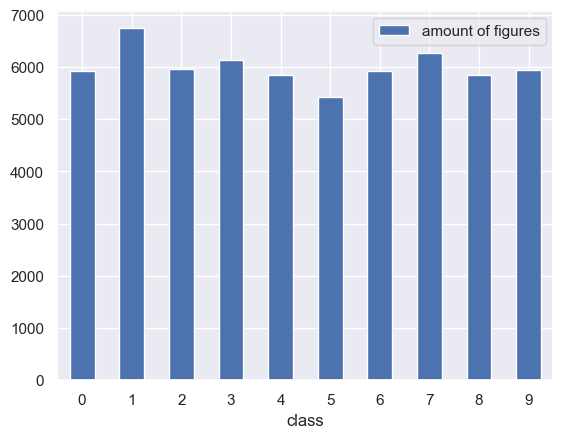

In [29]:
#依照class分群後，數各群的數量，並繪圖
dfCountPerClass = dfPath.groupby('class').count()
dfCountPerClass.rename(columns={'path':'amount of figures'}, inplace=True)
dfCountPerClass.plot(kind='bar', rot=0)

[回索引](#索引)

####  1.c. 將圖片路徑資料切割成三份：取其80%做為train data。 之後，剩下的20%中取一半做validation data，另一半做test data

shape(all figures)=		 (60000, 2)
shape(fraction of figures)=	 (12000, 2)
shape(train)=			 (9600, 2)
shape(trainVal)=		 (1200, 2)
shape(test)=			 (1200, 2)


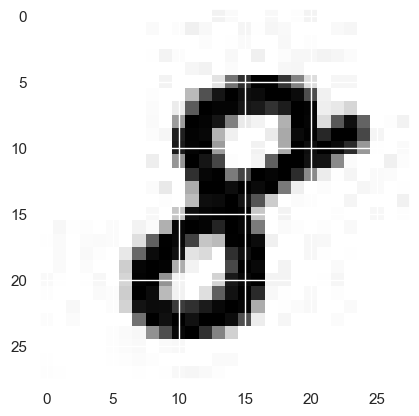

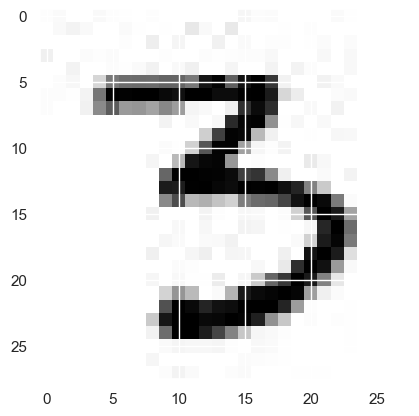

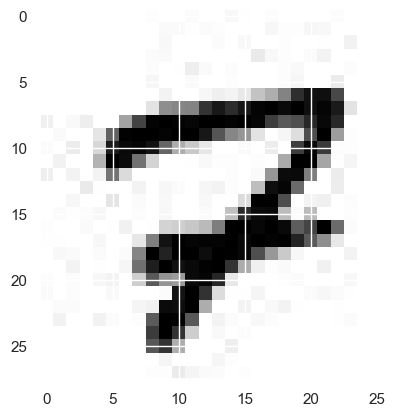

In [34]:
dfFrac=dfPath.sample(frac=0.2) # 打亂一下path data

train=dfFrac.sample(frac=0.8) # 將path data隨機取樣，80%的path data當train
test=dfFrac.drop(train.index) # 20%的path data當test

trainVal=test.sample(frac=0.5)
test=test.drop(trainVal.index)

print('shape(all figures)=\t\t', dfPath.shape)
print('shape(fraction of figures)=\t', dfFrac.shape)
print('shape(train)=\t\t\t', train.shape)
print('shape(trainVal)=\t\t', trainVal.shape)
print('shape(test)=\t\t\t', test.shape)

#隨便抓三張圖來看
for j in range(3):
    img=plt.imread(train['path'].iloc[j])
    plt.imshow(img, cmap="gray")
    plt.show()

[回索引](#索引)

####  1.d. 將圖片載入，存成數值矩陣

In [35]:
def dataLoad(dfPath):
    paths = dfPath['path'].values
    x = np.zeros((len(paths),28,28), dtype=np.float32)
    for j in range(len(paths)):
        x[j,:,:] = plt.imread(paths[j]) / 255.

    y = dfPath['class'].values
    return x, y

In [36]:
trainX, trainY = dataLoad(train)
trainValX, trainValY = dataLoad(trainVal)
testX, testY = dataLoad(test)

In [37]:
print('train:\t', trainX.shape, trainY.shape)
print('trainVal:', trainValX.shape, trainValY.shape)
print('test:\t', testX.shape, testY.shape)

train:	 (9600, 28, 28) (9600,)
trainVal: (1200, 28, 28) (1200,)
test:	 (1200, 28, 28) (1200,)


[回索引](#索引)

## 2. Softmax Regression

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD

#### 2.a. 將y 轉成one hot形式

In [39]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
trainYOneHot = enc.fit_transform(trainY.reshape(-1,1)) \
                  .toarray()

trainValYOneHot = enc.fit_transform(trainValY.reshape(-1,1)) \
                     .toarray()

testYOneHot = enc.fit_transform(testY.reshape(-1,1)) \
                 .toarray()

In [40]:
print('train:\t',trainX.shape,trainY.shape)
print('trainVal:',trainValX.shape,trainValY.shape)
print('test:\t',testX.shape,testY.shape)

train:	 (9600, 28, 28) (9600,)
trainVal: (1200, 28, 28) (1200,)
test:	 (1200, 28, 28) (1200,)


In [49]:
# plt.imshow(
# trainX[-1, ...], cmap='gray'
# )

[回索引](#索引)

#### 2.b. 開始建立模型

The softmax classifier's input: `[BS, num_features]`

A batch of images: shape= `[BS, H=28, W=28]` -> Flatten -> `[BS, H * W = 28 * 28 = 768]`

-> `Dense(units=10)` + softmax -> `[BS, 10]`

In [51]:
from tensorflow.keras.layers import Flatten

In [54]:
model = Sequential()
model.add(Flatten(input_shape=(28,28)))    # 此層將28X28的資料攤成1維
model.add(Dense(10, activation='softmax') )# 此層將以十個神經元輸出十種數字的個別機率

sgd=SGD(learning_rate = 0.05) 
model.compile(optimizer= sgd,             # 告知模型訓練方式 
      loss='categorical_crossentropy',
      metrics=['accuracy'])

In [56]:
28 * 28

784

In [55]:
# 檢視一下所訓練的模型
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


[回索引](#索引)

In [58]:
# trainable params = 784 x 10 + 1 x 10 = 7850

#### 2.c. 開始訓練模型

In [59]:
hist = model.fit(
    trainX,
    trainYOneHot,
    epochs=20, 
    batch_size=128,
    validation_data=(trainValX, trainValYOneHot)
)

Epoch 1/20
75/75 [==============================] - 1s 6ms/step - loss: 2.8775 - accuracy: 0.3489 - val_loss: 1.2465 - val_accuracy: 0.6267
Epoch 2/20
75/75 [==============================] - 0s 4ms/step - loss: 1.0637 - accuracy: 0.6850 - val_loss: 0.8933 - val_accuracy: 0.7067
Epoch 3/20
75/75 [==============================] - 0s 4ms/step - loss: 0.7334 - accuracy: 0.7809 - val_loss: 0.6947 - val_accuracy: 0.7867
Epoch 4/20
75/75 [==============================] - 0s 3ms/step - loss: 0.6266 - accuracy: 0.8114 - val_loss: 0.5847 - val_accuracy: 0.8300
Epoch 5/20
75/75 [==============================] - 0s 3ms/step - loss: 0.5548 - accuracy: 0.8363 - val_loss: 0.5801 - val_accuracy: 0.8225
Epoch 6/20
75/75 [==============================] - 0s 4ms/step - loss: 0.5274 - accuracy: 0.8418 - val_loss: 0.5136 - val_accuracy: 0.8517
Epoch 7/20
75/75 [==============================] - 0s 3ms/step - loss: 0.4799 - accuracy: 0.8554 - val_loss: 0.5282 - val_accuracy: 0.8517
Epoch 8/20
75/75 [==

[回索引](#索引)

#### 2.d. 檢視訓練好的模型用於test data有多少準確率

In [60]:
score = model.evaluate(testX, testYOneHot, batch_size=128)
print()
print('\nloss=%s \naccuracy=%s'%(score[0], score[1]))

10/10 [==============================] - 0s 6ms/step - loss: 0.4121 - accuracy: 0.8758


loss=0.4120909571647644 
accuracy=0.8758333325386047


[回索引](#索引)

#### 2.e. 檢視50筆測試資料的預測結果，以稍為了解預測是否還算ok

In [76]:
for idx in range(50):
    image = testX[np.newaxis, idx, ...]

    y_gt = testY[idx]
    y_pred = tf.squeeze(tf.argmax(
        model(image), 
        axis=-1,
    )).numpy()

    print(idx, y_gt, y_pred)

0 5 5
1 4 4
2 6 5
3 4 4
4 7 7
5 7 7
6 4 4
7 9 9
8 0 0
9 5 5
10 3 3
11 7 7
12 1 1
13 2 2
14 2 2
15 2 2
16 4 9
17 2 2
18 9 9
19 3 3
20 7 7
21 1 1
22 7 7
23 6 6
24 1 1
25 0 0
26 8 8
27 6 6
28 1 1
29 7 7
30 3 3
31 0 0
32 4 4
33 1 1
34 0 0
35 6 6
36 2 2
37 3 3
38 6 8
39 4 9
40 3 3
41 5 5
42 5 1
43 1 1
44 1 1
45 9 9
46 5 6
47 3 3
48 8 8
49 7 7


In [63]:
# for j in range(50):
#     predY= model.predict(trainValX[j:j+1,:]).argmax()
#     trueY= trainValYOneHot[j].argmax()
#     print( predY,trueY,end='\t')

[回索引](#索引)

#### 2.f. 畫出模型訓練過程

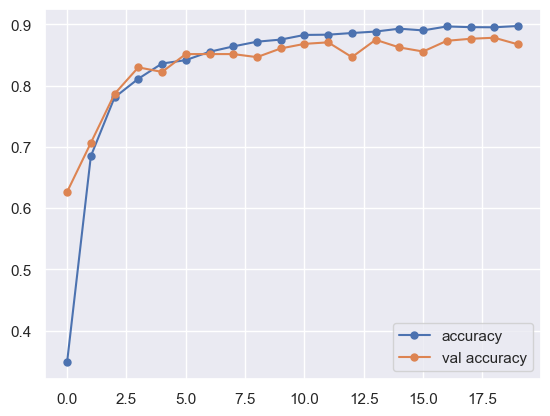

In [78]:
plt.plot(hist.history['accuracy'], ms=5, marker='o', label='accuracy')
plt.plot(hist.history['val_accuracy'], ms=5, marker='o', label='val accuracy')
plt.legend()
plt.show()

[回索引](#索引)

#### 2.g. 儲存模型和權重

In [ ]:
import json
with open('first_try.json', 'w') as jsOut:
    json.dump(model.to_json(), jsOut)

model.save_weights('first_try.h5')

[回索引](#索引)

#### 2.h. 載入存好的模型和權重

In [ ]:
from tensorflow.keras.models import model_from_json

In [ ]:
with open('first_try.json', 'r') as jsIn:
    modelJson=json.load(jsIn)
    
modelLoaded=model_from_json(modelJson)
modelLoaded.load_weights('first_try.h5')

In [ ]:
modelLoaded.summary()

[回索引](#索引)

#### 2.i. 輸出分類報告

In [80]:
from sklearn.metrics import classification_report

In [81]:
predY = model(testX).numpy().argmax(axis=1)

In [87]:
print(
    classification_report(testY.astype(np.int32), predY)
)

              precision    recall  f1-score   support

           0       0.95      0.94      0.94       129
           1       0.93      0.94      0.94       146
           2       0.91      0.80      0.85       109
           3       0.75      0.94      0.84       121
           4       0.94      0.88      0.91       104
           5       0.87      0.68      0.76       115
           6       0.91      0.94      0.92       124
           7       0.91      0.86      0.88       127
           8       0.84      0.84      0.84       121
           9       0.79      0.91      0.84       104

    accuracy                           0.88      1200
   macro avg       0.88      0.87      0.87      1200
weighted avg       0.88      0.88      0.88      1200



[回索引](#索引)

## 3. Simple Convolutional Neural Network

In [88]:
trainX = trainX.reshape(*trainX.shape, 1)
trainValX = trainValX.reshape(*trainValX.shape, 1)
testX = testX.reshape(*testX.shape, 1)

In [89]:
trainX.shape

(9600, 28, 28, 1)

#### 3.a. 建立模型

In [92]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten,Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import SGD,Adam,Adamax

input_shape = (28,28,1)

model = Sequential()

#conv1
model.add(Conv2D(filters=32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
          
#conv2
model.add(Conv2D(filters=64,
                 kernel_size=(3, 3),
                 activation='relu'))
#pool1
model.add(MaxPooling2D(pool_size=(2, 2)))
#conv3
model.add(Conv2D(filters=64,
                 kernel_size=(3, 3),
                 activation='relu'))
#pool2
model.add(MaxPooling2D(pool_size=(2, 2)))
#dropout1
model.add(Dropout(0.5))
model.add(Flatten())
#dense1
model.add(Dense(128, activation='relu'))
#dropout2
model.add(Dropout(0.5))
#dense2
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(learning_rate=0.05),
              metrics=['accuracy'])

[回索引](#索引)

#### 3.b. 訓練模型

In [93]:
%%time 
hist = model.fit(trainX, trainYOneHot, 
                 epochs=30,
                 batch_size=128,
                 validation_data=(trainValX,trainValYOneHot),
                )

Epoch 1/30
75/75 [==============================] - 4s 17ms/step - loss: 2.2746 - accuracy: 0.1644 - val_loss: 2.1810 - val_accuracy: 0.5308
Epoch 2/30
75/75 [==============================] - 1s 14ms/step - loss: 1.6755 - accuracy: 0.4474 - val_loss: 0.5778 - val_accuracy: 0.8700
Epoch 3/30
75/75 [==============================] - 1s 14ms/step - loss: 0.6672 - accuracy: 0.7814 - val_loss: 0.2762 - val_accuracy: 0.9333
Epoch 4/30
75/75 [==============================] - 1s 15ms/step - loss: 0.4358 - accuracy: 0.8605 - val_loss: 0.1974 - val_accuracy: 0.9492
Epoch 5/30
75/75 [==============================] - 1s 14ms/step - loss: 0.3451 - accuracy: 0.8950 - val_loss: 0.1719 - val_accuracy: 0.9492
Epoch 6/30
75/75 [==============================] - 1s 14ms/step - loss: 0.2882 - accuracy: 0.9099 - val_loss: 0.1488 - val_accuracy: 0.9567
Epoch 7/30
75/75 [==============================] - 1s 14ms/step - loss: 0.2609 - accuracy: 0.9225 - val_loss: 0.1327 - val_accuracy: 0.9600
Epoch 8/30
75

[回索引](#索引)

#### 3.c. 檢視模型訓練結果

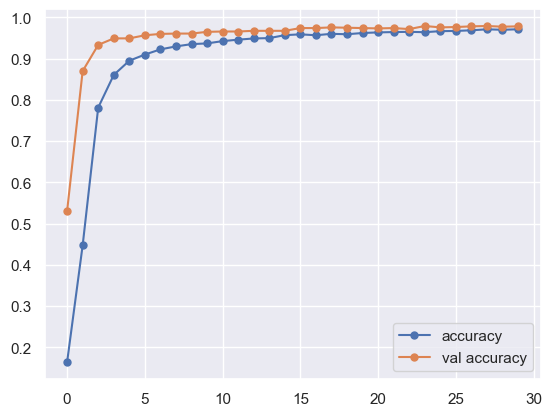

In [95]:
plt.plot(hist.history['accuracy'], ms=5, marker='o', label='accuracy')
plt.plot(hist.history['val_accuracy'], ms=5, marker='o', label='val accuracy')
plt.legend()
plt.show()

[回索引](#索引)

#### 3.d. 檢視模型準確率

In [96]:
score = model.evaluate(testX, testYOneHot, batch_size=128)
print()
print('\nloss=%s \naccuracy=%s'%(score[0], score[1]))

10/10 [==============================] - 0s 16ms/step - loss: 0.0547 - accuracy: 0.9842


loss=0.054667264223098755 
accuracy=0.98416668176651


[回索引](#索引)

#### 3.e. 檢視分類報告

In [98]:
from sklearn.metrics import classification_report

predY = model.predict(testX).argmax(axis=1)
print(classification_report(testY.astype(np.int32), predY))

38/38 [==============================] - 0s 10ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       129
           1       0.99      0.98      0.99       146
           2       0.97      1.00      0.99       109
           3       1.00      0.97      0.98       121
           4       1.00      0.98      0.99       104
           5       0.97      0.97      0.97       115
           6       0.98      0.98      0.98       124
           7       0.98      0.98      0.98       127
           8       0.96      0.99      0.98       121
           9       0.99      0.99      0.99       104

    accuracy                           0.98      1200
   macro avg       0.98      0.98      0.98      1200
weighted avg       0.98      0.98      0.98      1200



[回索引](#索引)